In [ ]:
import torch
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from src.utils.dataset import MNISTSampler
from src.utils.flow import GaussianConditionalProbabilityPath, LinearAlpha, LinearBeta
from architecture.nn_models import MNISTUNet
from src.utils.trainer import CFGTrainer


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

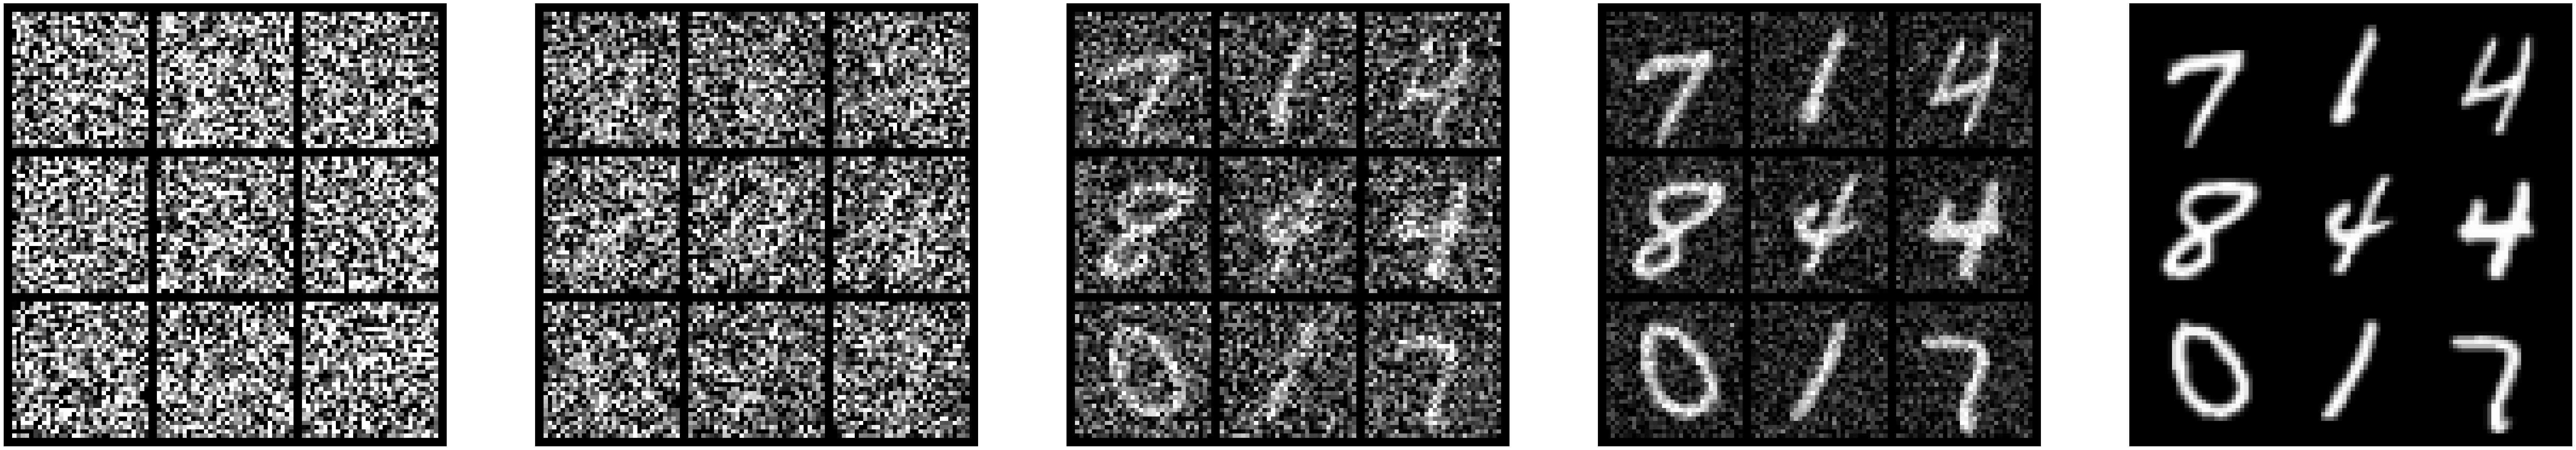

In [8]:
# Change these!
num_rows = 3
num_cols = 3
num_timesteps = 5

# Initialize our sampler
sampler = MNISTSampler().to(device)

# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Sample 
num_samples = num_rows * num_cols
z, _ = path.p_data.sample(num_samples)
z = z.view(-1, 1, 32, 32)

# Setup plot
fig, axes = plt.subplots(1, num_timesteps, figsize=(6 * num_cols * num_timesteps, 6 * num_rows))

# Sample from conditional probability paths and graph
ts = torch.linspace(0, 1, num_timesteps).to(device)
for tidx, t in enumerate(ts):
    tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = path.sample_conditional_path(z, tt) # (num_samples, 1, 32, 32)
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[tidx].axis("off")
plt.show()

In [ ]:
# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
unet = MNISTUNet(
    channels = [32, 64, 128],
    num_residual_layers = 2,
    t_embed_dim = 40,
    y_embed_dim = 40,
)

# Initialize trainer
trainer = CFGTrainer(path = path, model = unet, eta=0.1)

# Train!
trainer.train(num_epochs = 5000, device=device, lr=1e-3, batch_size=250)

Training model with size: 4.715 MiB


Epoch 21, loss: 434.076: : 22it [00:19,  1.11it/s]


KeyboardInterrupt: 